### Setup

In [11]:
# Imports
import numpy as np
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from data import Faultcreep
from data import Ridgecrest
from data import Kilauea

# Variables for execution
dataset = "S1-GUNW-D-R-071-tops-20190716_20190610-135212-36450N_34472N-PP-f29b-v2_0_2.nc"
shouldDownload = False

### Download Data

In [2]:
# Create temp dir (if required) and cd in
path = './temp'
if not os.path.exists(path):
    os.mkdir(path)
os.chdir(path)

# Run download if required
if(shouldDownload):
    Faultcreep.download()
    Ridgecrest.download()
    Kilauea.download()

# Return to correct folder
os.chdir("../")

 > Command line argument '--ip=127.0.0.1' makes no sense, ignoring.
 > Command line argument '--stdin=9003' makes no sense, ignoring.
 > Command line argument '--control=9001' makes no sense, ignoring.
 > Command line argument '--hb=9000' makes no sense, ignoring.
 > Command line argument '--Session.signature_scheme="hmac-sha256"' makes no sense, ignoring.
 > Command line argument '--Session.key=b"2d3d4e44-40f4-4298-9c6b-4f635d2ba366"' makes no sense, ignoring.
 > Command line argument '--shell=9002' makes no sense, ignoring.
 > Command line argument '--transport="tcp"' makes no sense, ignoring.
 > Command line argument '--iopub=9004' makes no sense, ignoring.
 > Command line argument '--f=c:\Users\samin\AppData\Roaming\jupyter\runtime\kernel-v2-14868IZQ2I0eSx1hp.json' makes no sense, ignoring.
 > attempting to download https://urs.earthdata.nasa.gov/profile
 > Reusing previous cookie jar.
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUN

### Open the .nc file

In [12]:
# Open dataset file
fp = f"./temp/{dataset}"
nc = netCDF4.Dataset(fp)

### Read Dataset File

In [13]:
lat_array = nc.groups['science'].groups['grids'].groups['data'].variables['latitude'][:].data
lon_array = nc.groups['science'].groups['grids'].groups['data'].variables['longitude'][:].data
image_extent = [np.min(lon_array),np.max(lon_array),np.min(lat_array),np.max(lat_array)]
wavelength = float(nc.groups['science'].groups['radarMetaData'].variables['wavelength'][:].data) * 100 #centimeters

mask_mat = nc.groups['science'].groups['grids'].groups['data'].variables['unwrappedPhase'][:].mask
unwrapped_phase_mat = nc.groups['science'].groups['grids'].groups['data'].variables['unwrappedPhase'][:].data    
coherence_mat = nc.groups['science'].groups['grids'].groups['data'].variables['coherence'][:].data    
amplitude_mat = nc.groups['science'].groups['grids'].groups['data'].variables['amplitude'][:].data    
cc_mat = amplitude_mat = nc.groups['science'].groups['grids'].groups['data'].variables['connectedComponents'][:].data  
nc.close()

### Filter by coherence

In [14]:
coherence_threshold = 0.5
inds_to_keep = (~mask_mat)* (coherence_mat>coherence_threshold)
mat_shape = inds_to_keep.shape
amp = np.zeros(mat_shape) + np.nan
amp[inds_to_keep] = amplitude_mat[inds_to_keep]
phase = np.zeros(mat_shape) + np.nan
phase[inds_to_keep] = unwrapped_phase_mat[inds_to_keep]
coherence = np.zeros(mat_shape) + np.nan
coherence[inds_to_keep] = coherence_mat[inds_to_keep]
connected_components = np.zeros(mat_shape) -1
connected_components[inds_to_keep] = cc_mat[inds_to_keep]

cc_uniq=np.unique(connected_components[connected_components>=0])
N_cc = len(cc_uniq)
cc2ind_dict = dict(zip(cc_uniq,np.arange(N_cc)))
cc2ind_dict[-1]=np.nan
connected_components=np.vectorize(cc2ind_dict.__getitem__)(connected_components)

phase_cm_units = wavelength * phase / (2*np.pi)

### Display Graphs

C:\Users\samin\AppData\Local\Temp\ipykernel_24324\1672107253.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2=plt.subplot(2,2,2,sharex=ax1,sharey=ax1)
C:\Users\samin\AppData\Local\Temp\ipykernel_24324\1672107253.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3=plt.subplot(2,2,3,sharex=ax1,sharey=ax1)
C:\Users\samin\AppData\Local\Temp\ipykernel_24324\1672107253.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax4=plt.subplot(2,2,4,sharex=ax1,sharey=ax1)


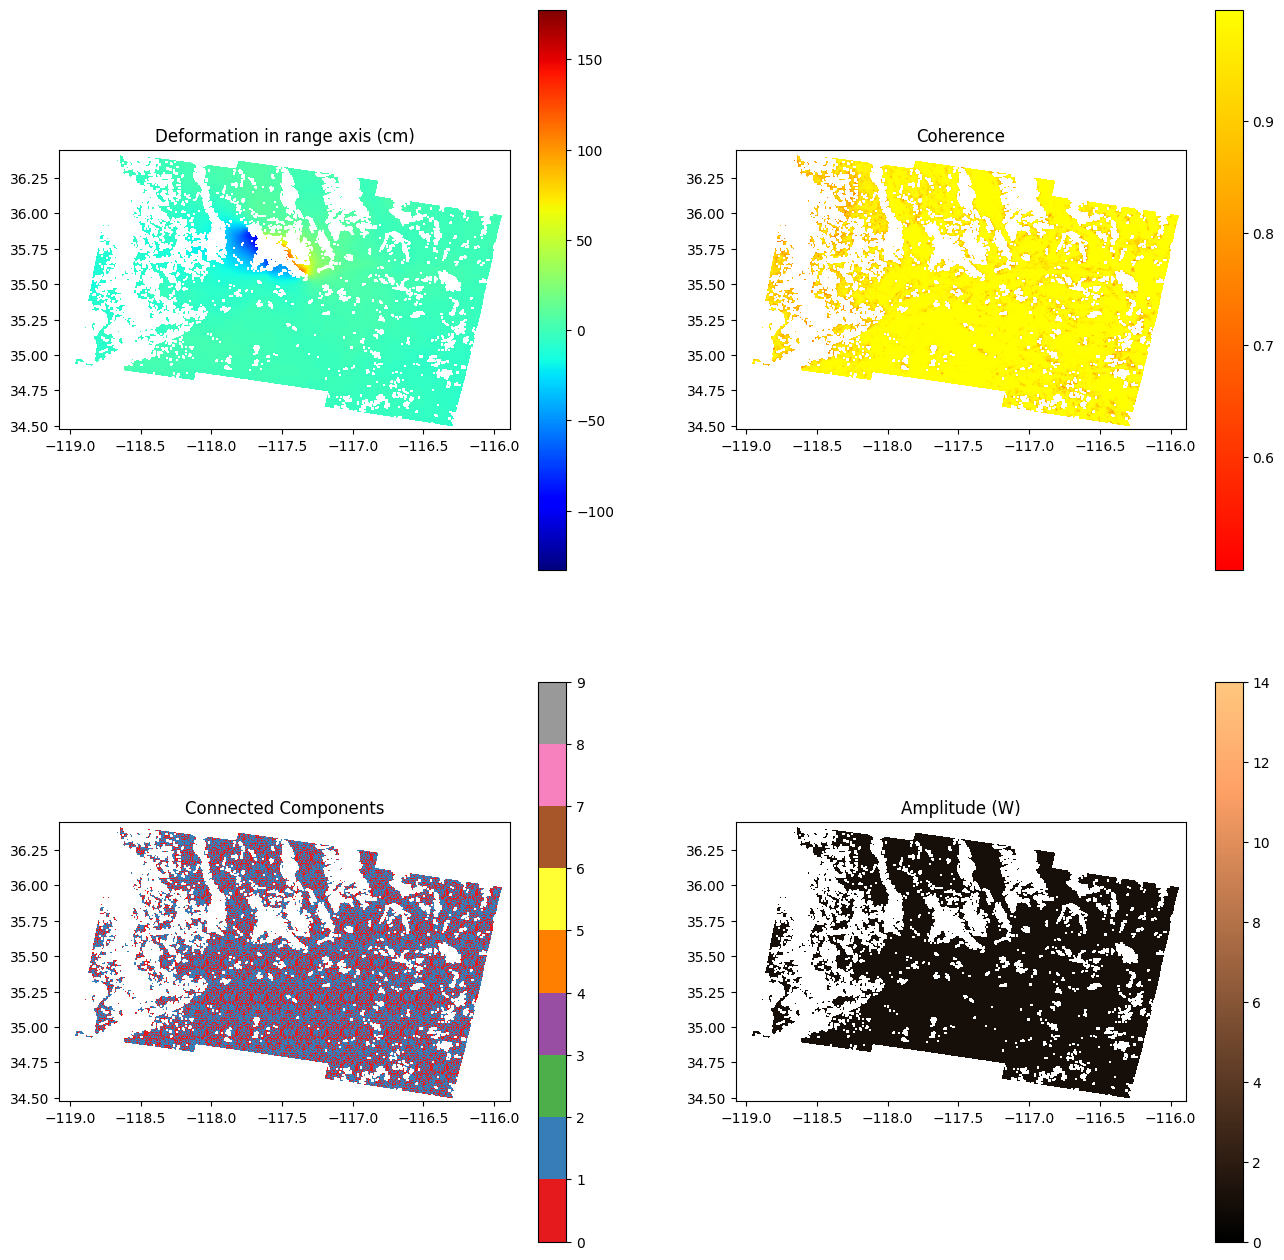

In [15]:
%matplotlib inline

fig,ax=plt.subplots(2,2,figsize = (16,16))

# Deformation
ax1=plt.subplot(2,2,1)
plt.imshow(phase_cm_units,extent = image_extent)
plt.set_cmap('jet')
plt.colorbar()
ax1.set_title('Deformation in range axis (cm)')

# Coherence
ax2=plt.subplot(2,2,2,sharex=ax1,sharey=ax1)
plt.imshow(coherence,extent = image_extent)
plt.set_cmap('autumn')
ax2.set_title('Coherence')
plt.colorbar()

# Connected components?
ax3=plt.subplot(2,2,3,sharex=ax1,sharey=ax1)
plt.imshow(connected_components,extent = image_extent)
plt.set_cmap('Set1')
ax3.set_title('Connected Components')
plt.colorbar()

# Amplitude
ax4=plt.subplot(2,2,4,sharex=ax1,sharey=ax1)
plt.imshow(amp,extent = image_extent)
plt.set_cmap('copper')
ax4.set_title('Amplitude (W)')

_ = plt.colorbar()

### Export Plot

In [16]:
path = './output'
if not os.path.exists(path):
    os.mkdir(path)

os.chdir(path)
fig.savefig(f"{dataset}.pdf", format="pdf", bbox_inches="tight")
os.chdir("../")